# Computer Vision Coursework Submission (IN3060/INM460)

**Student name, ID and cohort:** Elnara Mammadova (210026788) - PG

## Google Colab Setup

In [23]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [24]:
import os
path_to_folder = 'CW_Folder_PG' 
dir_path = os.path.join('drive', 'My Drive', path_to_folder)
print(os.listdir(dir_path))

['Coursework PG - Sit.pdf', 'Models', 'Video', 'Code', 'CW_Dataset', 'train_sift_x.csv', 'train_sift_y.csv', '.DS_Store', 'import_data.py', '.ipynb_checkpoints', 'sift_hist_arr.py', 'test_functions.ipynb']


## Import Dependencies

In [3]:
!pip install opencv-python==4.5.5.64

     |████████████████████████████████| 60.5 MB 85 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: imgaug, dopamine-rl, albumentations


## Import Libraries

In [5]:
import pandas as pd
import random
from imblearn.over_sampling import SMOTE
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pickle

%matplotlib inline

## Load Dataset

In [6]:
## === Code adapted from Lab_07 of INM460 === ##

# Identify path to zipped dataset
zip_path = os.path.join(dir_path, 'CW_Dataset', 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

In [7]:
def import_data(label_name):
    """Load images and labels for train and test set from selected directories"""
    images = []
    labels = []
    
    img_files = [img for img in sorted(os.listdir(label_name)) if img.endswith('.jpg')] # image files sorted in ascending order
    label_file = os.path.join('labels', 'list_label_'+label_name+'.txt') # label file corresponding to train or test
    for img in img_files:
      images.append(io.imread(os.path.join(label_name, img)))
    df = pd.read_csv(label_file, header=None, delimiter=r"\s+")
    df = df.sort_values(0) # sort (in ascending order) label dataframe by first column which are img names
    labels = df.iloc[:, 1].tolist()
    return images, labels

In [8]:
X_train, y_train = import_data('train')
X_test, y_test = import_data('test')

In [9]:
print(f'X_train shape: {np.shape(X_train)} \nX_test shape: {np.shape(X_test)}')

X_train shape: (12271, 100, 100, 3) 
X_test shape: (3068, 100, 100, 3)


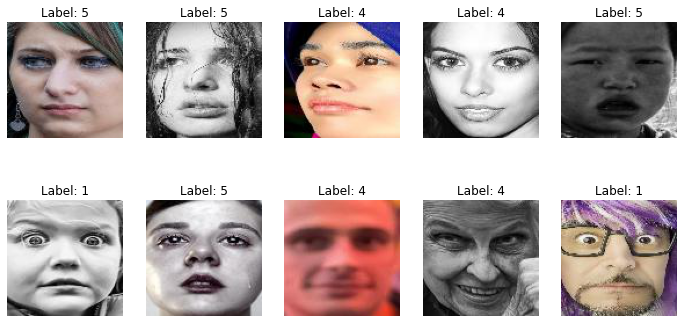

In [10]:
## === Code adapted from Lab_06 of INM460 === ##

X_train_img = np.array(X_train)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_train_img[i, :, :], cmap='gray')
    ax[i].set_title(f'Label: {y_train[i]}')
    ax[i].set_axis_off()
fig.tight_layout
plt.show()

In [11]:
y_train_counter = Counter(y_train)
y_test_counter = Counter(y_test) 

In [12]:
print(f'Train Labels: {y_train_counter} \nTest Labels: {y_test_counter}')

Train Labels: Counter({4: 4772, 7: 2524, 5: 1982, 1: 1290, 3: 717, 6: 705, 2: 281}) 
Test Labels: Counter({4: 1185, 7: 680, 5: 478, 1: 329, 6: 162, 3: 160, 2: 74})


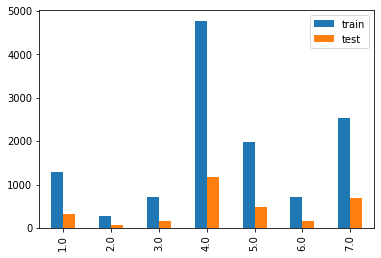

In [13]:
df = pd.DataFrame({'train': pd.Series(y_train_counter), 
                   'test': pd.Series(y_test_counter) })

ax = df.plot.bar()
labs = [round(float(t.get_text()), 1) for t in ax.axes.get_xmajorticklabels()]
ax.set_xticklabels(labs);

### Apply SMOTE
Since we have clear imbalance problem in our data, we will apply SMOTE (oversampling) to our data (training only).

In [14]:
sm = SMOTE(random_state=42)
num_rows=len(X_train)
# flatten the image to be able to pass to sklearn
X_train_reshaped = np.array(X_train).reshape(num_rows,-1)
print(f'Flattened X_train shape: {X_train_reshaped.shape}, y_train shape: {np.shape(y_train)}')

Flattened X_train shape: (12271, 30000), y_train shape: (12271,)


In [15]:
# apply smote on flattened image
X_train_sm, y_train = sm.fit_resample(X_train_reshaped, y_train)
print(f'Smoted X_train shape: {X_train_sm.shape}, y_train shape: {np.shape(y_train)}')

Smoted X_train shape: (33404, 30000), y_train shape: (33404,)


In [16]:
# reshape the flattened image back to its [num_samples, height, width, channel] dimensions
X_train = X_train_sm.reshape(-1,100,100,3)
print(f'New X_train shape: {X_train.shape}, y_train shape: {np.shape(y_train)}')

New X_train shape: (33404, 100, 100, 3), y_train shape: (33404,)


In [17]:
del X_train_reshaped, X_train_sm # to preserve ram memory

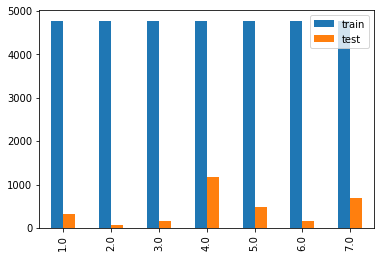

In [18]:
y_train_counter = Counter(y_train)
df = pd.DataFrame({'train': pd.Series(y_train_counter), 
                   'test': pd.Series(y_test_counter) })

ax = df.plot.bar()
labs = [round(float(t.get_text()), 1) for t in ax.axes.get_xmajorticklabels()]
ax.set_xticklabels(labs);

## Interest Point Detection and Feature Descriptors Extraction

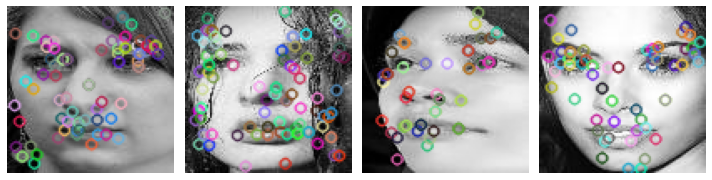

In [19]:
## === Code adapted from Lab_07 of INM460 === ##

# Initiate SIFT detector
sift = cv2.SIFT_create()

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)

for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    kp, des = sift.detectAndCompute(img, None)

    # Show results for first 4 images
    if i<4:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train[i])

del img, kp, des # delete variables that we won't be using to preserve RAM memory

fig.tight_layout()
plt.show()

# Convert to array for easier handling
des_array = np.vstack(des_list)

## Clustering of the descriptors

-- you can skip running the kmeans (which takes a long time) and just load the pretrained kmeans model from the pickle file that was saved


In [20]:
## === Code adapted from Lab_07 of INM460 === ##

# Number of centroids/codewords: good rule of thumb is 10*num_classes
k = len(np.unique(y_train)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)

Saving kmeans

In [27]:
pickle.dump(kmeans, open("kmeans.pkl", "wb"))

!cp kmeans.pkl /content/drive/MyDrive/CW_Folder_PG/Models/ 

## Generating histogram of codewords

In [28]:
## === Code adapted from Lab_07 of INM460 === ##

# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)
    kmeans_ = pickle.load(open("/content/drive/MyDrive/CW_Folder_PG/Models/kmeans.pkl", "rb"))
    idx = kmeans_.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

# we won't plot the histogram of codewords so as to save RAM memory

In [29]:
np.savetxt("drive/My Drive/CW_Folder_PG/CW_Dataset/SIFT_hist/train_sift_x.csv", hist_array, delimiter=",")
np.savetxt("drive/My Drive/CW_Folder_PG/CW_Dataset/SIFT_hist/train_sift_y.csv", y_train_list, delimiter=",")

## Train SVM with SIFT features

In [30]:
## === Code adapted from Lab_07 of INM460 === ##

# Create a classifier: a support vector classifier
classifier = svm.SVC(kernel='rbf', random_state=42) # random state for reproducibility
classifier.fit(hist_array, y_train_list)

SVC(random_state=42)

## Test SVM with SIFT features

In [31]:
%%time
## === Code adapted from Lab_07 of INM460 === ##

hist_list_test = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans_.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list_test.append(hist)

    else:
        hist_list_test.append(None)

del img, kp, des # delete variables that we won't be using to preserve RAM memory

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list_test) if x is not None]
hist_list_test = [hist_list_test[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array_test = np.vstack(hist_list_test)
print(f'Length of images with descriptors: {len(hist_array_test)}, Original number of images: {len(X_test)}')

Length of images with descriptors: 3066, Original number of images: 3068
CPU times: user 1min 26s, sys: 5.92 s, total: 1min 32s
Wall time: 24.5 s


In [32]:
np.savetxt("drive/My Drive/CW_Folder_PG/CW_Dataset/SIFT_hist/test_sift_x.csv", hist_array_test, delimiter=",")
np.savetxt("drive/My Drive/CW_Folder_PG/CW_Dataset/SIFT_hist/test_sift_y.csv", y_test, delimiter=",")

In [33]:
y_pred = classifier.predict(hist_array_test).tolist()

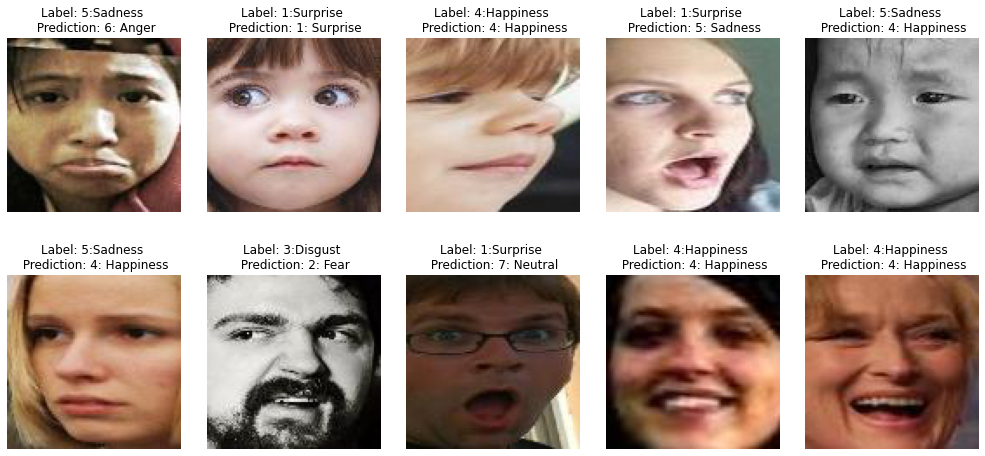

In [36]:
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()
classes = {1: "Surprise", 2: "Fear", 3: "Disgust", 4: "Happiness", 5: "Sadness", 6: "Anger", 7: "Neutral"}  
for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]}:{classes[y_test[i]]} \n Prediction: {y_pred[i]}: {classes[y_pred[i]]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [37]:
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test, y_pred)}\n""")

Classification report for classifier SVC(random_state=42):
                    precision    recall  f1-score   support

           1       0.24      0.24      0.24       329
           2       0.09      0.16      0.11        74
           3       0.09      0.10      0.09       160
           4       0.49      0.55      0.52      1184
           5       0.27      0.13      0.18       478
           6       0.19      0.15      0.17       162
           7       0.32      0.33      0.33       679

    accuracy                           0.35      3066
   macro avg       0.24      0.24      0.24      3066
weighted avg       0.34      0.35      0.34      3066




In [38]:
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_test,y_pred))

Accuracy on unknown data is 0.3519243313763862


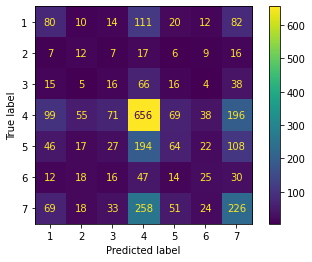

In [45]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

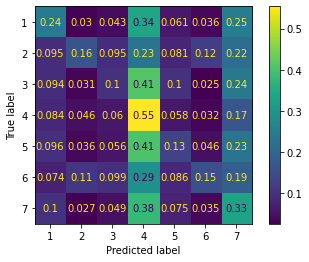

In [44]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()

## Grid Search

In [49]:
# Performing CV to tune parameters for best SVM fit 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
params_grid = [{'kernel': ['rbf'], 
                'gamma': ['scale', 1e-3, 1e-4],
                'C': [1, 10, 100, 1000],
                }]

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
svm_model = GridSearchCV(svm.SVC(), params_grid, cv=cv, scoring='f1_micro', return_train_score=True, verbose=2)
svm_model.fit(hist_array, y_train_list)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 2.3min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 2.3min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 2.2min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 2.2min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 2.3min
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time= 3.0min
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time= 3.0min
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time= 2.8min
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time= 2.9min
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time= 2.7min
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time= 2.7min
[CV] END ......................C=1, gamma=0.0001

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': ['scale', 0.001, 0.0001],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='f1_micro', verbose=2)

In [50]:
# View the accuracy score
print(f'GS result: {svm_model.best_score_}, best C: {svm_model.best_estimator_.C}, best gamma: {svm_model.best_estimator_.gamma}')

GS result: 0.31610778443113774, best C: 10, best gamma: scale


## Final Model

In [51]:
final_SVM_model = svm_model.best_estimator_
y_pred = final_SVM_model.predict(hist_array_test).tolist()

In [52]:
print("Accuracy on unknown data is",accuracy_score(y_test,y_pred))

Accuracy on unknown data is 0.31604696673189825


In [57]:
print(f"""Classification report for SVM with SIFT descriptors:
      {metrics.classification_report(y_test, y_pred)}\n""")

Classification report for SVM with SIFT descriptors:
                    precision    recall  f1-score   support

           1       0.19      0.22      0.21       329
           2       0.11      0.16      0.13        74
           3       0.10      0.16      0.12       160
           4       0.47      0.49      0.48      1184
           5       0.22      0.18      0.20       478
           6       0.12      0.10      0.11       162
           7       0.30      0.26      0.28       679

    accuracy                           0.32      3066
   macro avg       0.22      0.22      0.22      3066
weighted avg       0.32      0.32      0.32      3066




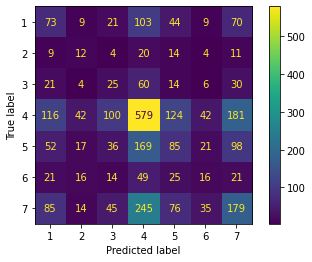

In [54]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

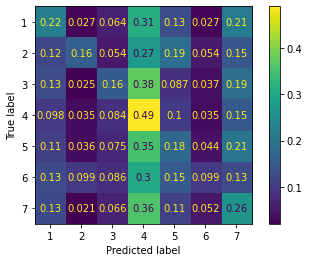

In [58]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()

In [55]:
from joblib import dump, load
dump(final_SVM_model, 'SVM_SIFT.joblib') 

['SVM_SIFT.joblib']

In [56]:
!cp -av "/content/SVM_SIFT.joblib" "/content/drive/MyDrive/CW_Folder_PG/Models"

'/content/SVM_SIFT.joblib' -> '/content/drive/MyDrive/CW_Folder_PG/Models/SVM_SIFT.joblib'
